## Loading train labels with image name and level

In [2]:
import pandas as pd

trainLabels = pd.read_csv('trainLabels.csv')
trainLabels.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [3]:
import os
import glob

In [4]:
print(os.getcwd())

C:\Users\defoe\Diabetic


In [5]:
TRAINDIR = 'D:/Diabetic Retinopathy Data/train'
TESTDIR = 'D:/Diabetic Retinopathy Data/test'

In [6]:
train_dir = os.path.join(TRAINDIR,'train')
train_file = glob.glob(train_dir+'/*.jpeg')
test_dir = os.path.join(TESTDIR,'test')
test_file = glob.glob(test_dir+'/*.jpeg')

In [7]:
len(train_file) ,len(test_file)

(35126, 53576)

In [8]:
import numpy as np
import pandas as pd

np.random.seed(42)

train_df = pd.DataFrame({
    'filename': train_file,
    'level': trainLabels['level']
}).sample(frac=1, random_state=111).reset_index(drop=True)

train_df.head()

,filename,level
0,D:/Diabetic Retinopathy Data/train\train\29162...,0
1,D:/Diabetic Retinopathy Data/train\train\7896_...,0
2,D:/Diabetic Retinopathy Data/train\train\22557...,0
3,D:/Diabetic Retinopathy Data/train\train\34482...,2
4,D:/Diabetic Retinopathy Data/train\train\14356...,2


In [9]:
test_df = pd.DataFrame({
    'filename': test_file,
}).sample(frac=0.16,random_state=111).reset_index(drop=True)

test_df.head()

,filename
0,D:/Diabetic Retinopathy Data/test\test\44311_l...
1,D:/Diabetic Retinopathy Data/test\test\26998_l...
2,D:/Diabetic Retinopathy Data/test\test\12562_r...
3,D:/Diabetic Retinopathy Data/test\test\8775_le...
4,D:/Diabetic Retinopathy Data/test\test\16942_l...


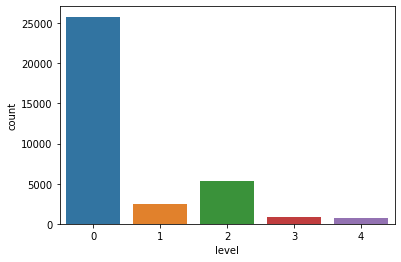

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(train_df['level'])
plt.show()

In [12]:
from sklearn.model_selection import train_test_split
from collections import Counter

train_files, val_files, train_labels, val_labels = train_test_split(train_df['filename'].values,
                                                                    train_df['level'], 
                                                                    test_size=0.1, random_state=42)

In [13]:
print(train_files.shape, val_files.shape)
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels))

(31613,) (3513,)
Train: Counter({0: 23232, 2: 4734, 1: 2206, 3: 786, 4: 655}) 
Val: Counter({0: 2578, 2: 558, 1: 237, 3: 87, 4: 53})


In [14]:
import cv2
from concurrent import futures
import threading

In [15]:
def get_img_shape_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
        return cv2.imread(img).shape
    
ex = futures.ThreadPoolExecutor(max_workers=None)
data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
print('Starting Img shape computation:')
train_img_dims_map = ex.map(get_img_shape_parallel, 
                            [record[0] for record in data_inp],
                            [record[1] for record in data_inp],
                            [record[2] for record in data_inp])
train_img_dims = list(train_img_dims_map)
print('Min Dimensions:', np.min(train_img_dims, axis=0)) 
print('Avg Dimensions:', np.mean(train_img_dims, axis=0))
print('Median Dimensions:', np.median(train_img_dims, axis=0))
print('Max Dimensions:', np.max(train_img_dims, axis=0))

Starting Img shape computation:
ThreadPoolExecutor-0_0: working on img num: 0
ThreadPoolExecutor-0_2: working on img num: 5000
ThreadPoolExecutor-0_0: working on img num: 10000
ThreadPoolExecutor-0_39: working on img num: 15000
ThreadPoolExecutor-0_0: working on img num: 20000
ThreadPoolExecutor-0_6: working on img num: 25000
ThreadPoolExecutor-0_63: working on img num: 30000
ThreadPoolExecutor-0_13: working on img num: 31612


TypeError: '<=' not supported between instances of 'tuple' and 'NoneType'

In [16]:
IMG_DIMS = (125, 125)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_DIMS, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]
test_data_inp = [(idx, img, len(test_df['filename'])) for idx, img in enumerate(test_df['filename'])]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape, val_data.shape , test_data.shape 

Loading Train Images:
ThreadPoolExecutor-1_0: working on img num: 0
ThreadPoolExecutor-1_69: working on img num: 5000
ThreadPoolExecutor-1_30: working on img num: 10000
ThreadPoolExecutor-1_5: working on img num: 15000
ThreadPoolExecutor-1_74: working on img num: 20000
ThreadPoolExecutor-1_38: working on img num: 25000
ThreadPoolExecutor-1_40: working on img num: 30000
ThreadPoolExecutor-1_39: working on img num: 31612

Loading Validation Images:
ThreadPoolExecutor-1_73: working on img num: 0
ThreadPoolExecutor-1_51: working on img num: 3512

Loading Test Images:
ThreadPoolExecutor-1_50: working on img num: 0
ThreadPoolExecutor-1_40: working on img num: 5000
ThreadPoolExecutor-1_11: working on img num: 8571


((31613, 125, 125, 3), (3513, 125, 125, 3), (8572, 125, 125, 3))

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

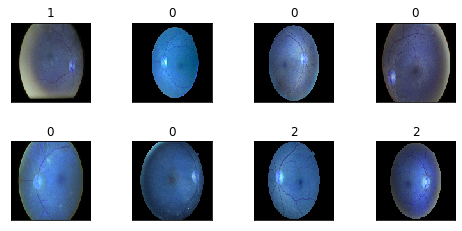

In [19]:
plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(8):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

In [20]:
BATCH_SIZE = 64
NUM_CLASSES = 5
EPOCHS = 25
INPUT_SHAPE = (125, 125, 3)

train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.


In [40]:
import tensorflow as tf

In [44]:
inp = tf.keras.layers.Input(shape=INPUT_SHAPE)

conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), 
                               activation='relu', padding='same')(inp)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), 
                               activation='relu', padding='same')(pool1)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), 
                               activation='relu', padding='same')(pool2)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

flat = tf.keras.layers.Flatten()(pool3)

hidden1 = tf.keras.layers.Dense(512, activation='relu')(flat)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(5, activation='softmax')(drop2)

model = tf.keras.Model(inputs=inp, outputs=out)
model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 125, 125, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 125, 125, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 31, 31, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 128)       0   

In [45]:
history = model.fit(x=train_imgs_scaled, y=train_labels, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(val_imgs_scaled, val_labels), 
                    verbose=1)

Train on 31613 samples, validate on 3513 samples
Epoch 1/25
31613/31613 [==============================] - 507s 16ms/sample - loss: 0.8918 - acc: 0.7339 - val_loss: 0.8578 - val_acc: 0.7338
Epoch 2/25
31613/31613 [==============================] - 499s 16ms/sample - loss: 0.8765 - acc: 0.7349 - val_loss: 0.8614 - val_acc: 0.7338
Epoch 3/25
31613/31613 [==============================] - 523s 17ms/sample - loss: 0.8728 - acc: 0.7349 - val_loss: 0.8585 - val_acc: 0.7338
Epoch 4/25
31613/31613 [==============================] - 519s 16ms/sample - loss: 0.8713 - acc: 0.7349 - val_loss: 0.8578 - val_acc: 0.7338
Epoch 5/25
31613/31613 [==============================] - 502s 16ms/sample - loss: 0.8713 - acc: 0.7349 - val_loss: 0.8576 - val_acc: 0.7338
Epoch 6/25
31613/31613 [==============================] - 495s 16ms/sample - loss: 0.8713 - acc: 0.7349 - val_loss: 0.8592 - val_acc: 0.7338
Epoch 7/25
31613/31613 [==============================] - 510s 16ms/sample - loss: 0.8709 - acc: 0.7349 -